# ResNets

This week we discussed ResNets which are convolutional neural networks but with a residual learning framework realized by creating residual blocks via shortcut connections. In this notebook, we'll be implementing a fully connected NN, a plain CNN and a residual network and comparing the results on the MNIST dataset.

We'll start off by loading the data. We'll be working with the MNIST dataset, which provides 70,000 labeled 28x28 images of handwritten digits. Our goal is to construct a classifier that recognizes handwritten digits.

In [22]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms

%matplotlib inline

# Load the dataset... This can take a while
if("mnist" not in globals()):  # Don't load the dataset twice...
    mnist = fetch_openml('mnist_784', version=1)
    # Convert DataFrame to 24x24 numpy arrays...
    imgs = mnist.data.to_numpy().reshape(70000, 28, 28).astype(np.float32)
    # Labels for the mnist data, 0-9 being the number...
    labels = np.asarray(mnist.target).astype(int)
    
    imgs_train, imgs_test, labels_train, labels_test = train_test_split(
        imgs, labels, test_size=0.2, random_state=1
    )


Let's plot one of the digits at random to see what they look like.

C:\Users\PRIMEL~1\AppData\Local\Temp/ipykernel_10592/3762573748.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


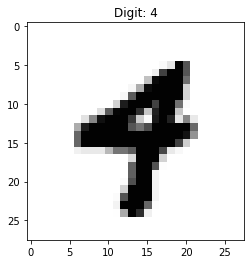

In [23]:
idx = np.random.randint(0, imgs.shape[0])
single_digit = imgs[idx]
single_label = labels[idx]

fig, ax = plt.subplots(1, 1)
ax.set_title(f"Digit: {single_label}")
ax.imshow(single_digit, cmap="Greys")
fig.show()

We'll attempt to use a GPU to run these models. We'll check if one is available and assign it to our device.

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches” and reshuffle the data at every epoch to reduce model overfitting. 

In [7]:
# Set the batch size:
batch_size = 256

# Set up data loaders, these will be used to train and test models...
to_device = lambda a: torch.from_numpy(a).to(device)

train_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_train), to_device(labels_train)),
    batch_size = batch_size,
    shuffle = True
)

test_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_test), to_device(labels_test)),
    batch_size = batch_size,
    shuffle = True
)

## Simple Model: Fully Connected NN

Now that we have our data set-up, let's start to implement our first network: a fully connected neural network.

In [8]:
class SimpleNet(nn.Module):
    def __init__(
        self, 
        img_w: int, 
        img_h: int, 
        hidden_layer_sizes: list, 
        class_size: int
    ):
        super().__init__()
        
        self._in_layer = nn.Linear(img_w * img_h, hidden_layer_sizes[0])
        
        layers = []
        for hls1, hls2 in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([nn.Linear(hls1, hls2), nn.ReLU()])
        
        self._hidden_layers = nn.Sequential(*layers)
        
        self._out_layer = nn.Linear(hidden_layer_sizes[-1], class_size)
        self._softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = x.reshape(-1, img_w * img_h)
        
        x = self._in_layer(x)
        x = self._hidden_layers(x)
        return self._softmax(self._out_layer(x))

Let's define some variables to use with our simple network.

In [19]:
# Set these!
img_w = 28  # Height of the images
img_h = 28  # Width of the images
hidden_layer_sizes = [10, 10, 10]
class_size = 10  # Size of output

simple_net = SimpleNet(img_w, img_h, hidden_layer_sizes, class_size)
simple_net.to(device)

SimpleNet(
  (_in_layer): Linear(in_features=784, out_features=10, bias=True)
  (_hidden_layers): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (_out_layer): Linear(in_features=10, out_features=10, bias=True)
  (_softmax): Softmax(dim=1)
)

We also want some functions to see how our network performs. These are defined below:

In [20]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs, 
    augment_method=None, 
    print_every=300
):
    for epoch_i in range(1, n_epochs + 1):
        for i, (img, label) in enumerate(train_data, 1):
            model.zero_grad()
            # If an augmentation method is passed, use it before passing the image to the model.
            predicted = model.forward(img if(augment_method is None) else augment_method(img))
            loss = error_func(predicted, label.to(torch.long))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        acc1 = get_accuracy(model, train_data, augment_method)
        print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
        acc2 = get_accuracy(model, test_data, augment_method)
        print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data, im_mod = None):
    run = 0
    correct = 0

    for img, label in data:
        img = im_mod(img) if(im_mod is not None) else img   # Allows us to modify the images...
        run += len(img)
        result = model.forward(img).cpu().detach().numpy()
        correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())

    return correct / run

Let's set a number of epochs and a learning rate for the model and see how it does.

In [21]:
# Set these!
n_epochs = 20
lr = 1e-3

# Set up everything...
optimizer = optim.Adam(simple_net.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [22]:
# Train the model...
simple_net = train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs)

Epoch: 1/20, Iter: 219/219, Loss: 1.9614
Epoch 1 Train Accuracy: 47.49%
Epoch 1 Test Accuracy: 47.60%

Epoch: 2/20, Iter: 219/219, Loss: 1.8904
Epoch 2 Train Accuracy: 55.41%
Epoch 2 Test Accuracy: 55.60%

Epoch: 3/20, Iter: 219/219, Loss: 1.8930
Epoch 3 Train Accuracy: 57.21%
Epoch 3 Test Accuracy: 57.44%

Epoch: 4/20, Iter: 219/219, Loss: 1.8072
Epoch 4 Train Accuracy: 67.43%
Epoch 4 Test Accuracy: 66.89%

Epoch: 5/20, Iter: 219/219, Loss: 1.6261
Epoch 5 Train Accuracy: 79.38%
Epoch 5 Test Accuracy: 78.83%

Epoch: 6/20, Iter: 219/219, Loss: 1.6424
Epoch 6 Train Accuracy: 81.64%
Epoch 6 Test Accuracy: 81.05%

Epoch: 7/20, Iter: 219/219, Loss: 1.6258
Epoch 7 Train Accuracy: 82.45%
Epoch 7 Test Accuracy: 81.76%

Epoch: 8/20, Iter: 219/219, Loss: 1.5665
Epoch 8 Train Accuracy: 87.83%
Epoch 8 Test Accuracy: 87.00%

Epoch: 9/20, Iter: 219/219, Loss: 1.5359
Epoch 9 Train Accuracy: 90.25%
Epoch 9 Test Accuracy: 89.18%

Epoch: 10/20, Iter: 219/219, Loss: 1.5365
Epoch 10 Train Accuracy: 91.56%

### Is this model robust to translations?

Our initial results are pretty good! Let's see the accuracy when we "shift" the image data around a little bit...

In [23]:
img_transform = transforms.RandomAffine((-10, 10), (0.2, 0.2), (0.8, 1.2), (-5, 5))

def img_shift_and_warp(img: torch.tensor) -> torch.tensor:
    if(len(img.shape) == 2):
        img = img.reshape(1, *img.shape)   
    img = img_transform(img)
    return img
    

# Show what img_shift_and_warp does to our images...
random_idx = np.random.randint(0, len(imgs))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original Image")
ax2.set_title("Shifted Image")
ax1.imshow(imgs[random_idx], cmap="Greys")
ax2.imshow(img_shift_and_warp(torch.from_numpy(imgs[random_idx]))[0], cmap="Greys")

fig.show()

<IPython.core.display.Javascript object>

In [24]:
print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 92.66%
Augmented Test Accuracy: 24.86%


Yikes! Shifting around the numbers destroys the accuracy of our simple fully connected network destroys its performance. Can we fix this through data augmentation?

In [25]:
# Train the model...
simple_net = train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs, img_shift_and_warp)

Epoch: 1/20, Iter: 219/219, Loss: 2.0973
Epoch 1 Train Accuracy: 31.11%
Epoch 1 Test Accuracy: 29.45%

Epoch: 2/20, Iter: 219/219, Loss: 2.0264
Epoch 2 Train Accuracy: 34.52%
Epoch 2 Test Accuracy: 32.92%

Epoch: 3/20, Iter: 219/219, Loss: 2.1830
Epoch 3 Train Accuracy: 37.66%
Epoch 3 Test Accuracy: 35.39%

Epoch: 4/20, Iter: 219/219, Loss: 2.0376
Epoch 4 Train Accuracy: 39.26%
Epoch 4 Test Accuracy: 43.53%

Epoch: 5/20, Iter: 219/219, Loss: 1.9553
Epoch 5 Train Accuracy: 44.36%
Epoch 5 Test Accuracy: 42.29%

Epoch: 6/20, Iter: 219/219, Loss: 2.1431
Epoch 6 Train Accuracy: 47.00%
Epoch 6 Test Accuracy: 43.80%

Epoch: 7/20, Iter: 219/219, Loss: 1.9974
Epoch 7 Train Accuracy: 47.34%
Epoch 7 Test Accuracy: 44.60%

Epoch: 8/20, Iter: 219/219, Loss: 2.0210
Epoch 8 Train Accuracy: 47.21%
Epoch 8 Test Accuracy: 45.99%

Epoch: 9/20, Iter: 219/219, Loss: 2.0225
Epoch 9 Train Accuracy: 47.52%
Epoch 9 Test Accuracy: 45.21%

Epoch: 10/20, Iter: 219/219, Loss: 1.7296
Epoch 10 Train Accuracy: 47.48%

In [26]:
print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 71.15%
Augmented Test Accuracy: 49.03%


Even after training the network using augmented images, we can see that a fully connected network still performs worse on transformed images. Even more interesting, is that the network now performs more poorly on the original data.

### Question

__Why do you think the model performs more poorly on the original data when trained on augmented data?__
In this case, the fully connected NN is poorly suited to the task - it will do fine when the data for classes are well defined but in this example where there is noise within class data it struggles to interpret what each class looks like, and thus has a hard time learning the differences between the classes.

# Using a ResNet

Now that we've looked at a fully connected network and a, let's see if we can achieve even better results with a residual network (ResNet).

We'll start by defining a residual block. Let's do a quick recap on what this is.

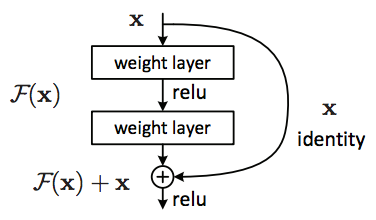

Here we let $H(\textbf{x})$ be the output of a few stacked nonlinear layers where $\textbf{x}$ is the input to the first of these layers. 
We'll let these stacked layers fit a residual mapping (the difference between the input and output) with $F(\textbf{x}) = H(\textbf{x}) - \textbf{x}$.
Our original function now becomes $H(\textbf{x}) = F(\textbf{x}) + \textbf{x}$. We expect this to be easier for the solvers to optimize as opposed to the original unreferenced mapping.

A residual block can be formally defined with the equation
$\textbf{y} = F(\textbf{x}, \{W_{i}\}) + W_s\textbf{x}$ where $\textbf{x}, \textbf{y}$ are the input and output vectors and $F(\textbf{x}, \{W_{i}\})$ is the residual mapping to be learned.
For the example block shown here (what we'll be implementing) with two weight layers and a ReLU function, we let $F = W_2 \sigma (W_1\textbf{x})$

The main thing to takeaway from residual blocks (and what makes ResNets differ from plain CNNs) is the use of the identity shortcut connection which allows the input to be added to the output of the stacked layers.

In [27]:
class ResidualBlock(nn.Module):
    """
    A single residual block.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1):
        super().__init__()
        
        if(kernel_size % 2 == 0):
            raise ValueError("Kernel size must be odd!")
            
        self._in_channels = in_channels
        self._out_channels = out_channels
        
        self._conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self._relu = nn.ReLU()
        self._conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size // 2)
        
        if(stride == 1):
            self._identity = nn.Identity()
        else:
            # As paper suggests use convolution with 1x1 kernel and stride of 2 to linearly downsample the data
            self._identity = nn.Conv2d(in_channels, out_channels, (1, 1), 2)
        
        self._relu2 = nn.ReLU()
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        # Non-Linear part...
        x_nonlinear = self._conv2(self._relu(self._conv1(x)))
        # Linear part...
        x_linear = self._identity(x)
        return self._relu2(x_nonlinear + x_linear)

    
class VanillaBlock(nn.Module):
    """
    A single vanilla block (no skip connections).
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1):
        super().__init__()
        
        if(kernel_size % 2 == 0):
            raise ValueError("Kernel size must be odd!")
            
        self._in_channels = in_channels
        self._out_channels = out_channels
        
        self._conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self._relu = nn.ReLU()
        self._conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size // 2)
        self._relu2 = nn.ReLU()
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        x_nonlinear = self._conv2(self._relu(self._conv1(x)))     
        return self._relu2(x_nonlinear)


Now, we'll define a network capable of taking a layer description list and building a ResNet style CNN out of this list.

In [28]:
class ResNet(nn.Module):
    def __init__(self,
        in_channels: int,
        hidden_size: int, 
        output_size: int,
        start_depth: int = 64
    ):
        super().__init__()
        
        self._output_size = output_size
        self._in_channels = in_channels
        
        l_in = start_depth
        
        self._initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, l_in, 7, stride=1, padding=3),  # Modification, remove stride, makes final image too small...
            nn.MaxPool2d(3, 2, padding=1)
        )
        
        # Output dims, kernel size, stride, amount...
        layers = self.get_layers(start_depth)
        
        self._final_layer_len = layers[-1][0]
        
        residual_layers = []
                
        for l_out, kernel, stride, count, block_cls in layers:
            for i in range(count):
                res = block_cls(l_in, l_out, kernel, stride)
                residual_layers.append(res)
            l_in = l_out
        
        self._residual_blocks = nn.Sequential(*residual_layers)
        
        self._final_pooling = nn.AdaptiveAvgPool2d(1)
        
        self._fully_connected = nn.Sequential(
            nn.Linear(self._final_layer_len, hidden_size),
            nn.Linear(hidden_size, output_size)
        )
        self._softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor, run_pooling: bool=True) -> torch.tensor:
        batch_size = x.shape[0]
        im_shape = x.shape[1:] if(len(x.shape) == 3) else x.shape[2:]
        
        x = x.reshape(batch_size, self._in_channels, *im_shape)
        x = self._initial_conv(x)
        x = self._residual_blocks(x)
        
        if(run_pooling):
            x = torch.moveaxis(self._final_pooling(x), 1, -1)
            x = x.reshape(-1, self._final_layer_len)
            return self._softmax(self._fully_connected(x))
        else:
            # No pooling: Run the classifier on every pixel in the image...
            im_shape = x.shape[2:]
            x = torch.moveaxis(x, 1, -1).reshape(-1, self._final_layer_len)
            x = self._fully_connected(x)
            return x.reshape(batch_size, *im_shape, self._output_size)
            
    def get_layers(self, start_depth) -> list:
        raise NotImplementedError("Use one of the ResNet subclasses!")
        

Now we can use this class to define several types of ResNets and regular CNNs

In [29]:
# Layers: A list of tuples which describe the following in order:
# (CNN layer depth, kernel size, stride, number of blocks, block class)
        
class VanillaNet18(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 2, VanillaBlock),
            (l_in * 2, 3, 2, 1, VanillaBlock),
            (l_in * 2, 3, 1, 1, VanillaBlock),
            (l_in * 4, 3, 2, 1, VanillaBlock),
            (l_in * 4, 3, 1, 1, VanillaBlock),
            (l_in * 8, 3, 2, 1, VanillaBlock),
            (l_in * 8, 3, 1, 1, VanillaBlock)
        ]
    
class ResNet18(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 2, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 1, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 1, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 1, ResidualBlock)
        ]
    
class VanillaNet34(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 3, VanillaBlock),
            (l_in * 2, 3, 2, 1, VanillaBlock),
            (l_in * 2, 3, 1, 3, VanillaBlock),
            (l_in * 4, 3, 2, 1, VanillaBlock),
            (l_in * 4, 3, 1, 5, VanillaBlock),
            (l_in * 8, 3, 2, 1, VanillaBlock),
            (l_in * 8, 3, 1, 2, VanillaBlock)
        ]
    
class ResNet34(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 3, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 3, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 5, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 2, ResidualBlock)
        ]

We'll define a new ResNet (or non-ResNet) below.

In [37]:
# What values should be here?
in_channels = 1  # Number of channels in passed data...
output_size = 10  # Number of output nodes.
channel_start = 8  # Number of channels to start the residual blocks with.
hidden_layer_size = 10  # Size of the fully connected hidden layer at the end.
model_class = ResNet34  # The model class to use.

res_net = model_class(in_channels, hidden_layer_size, output_size, channel_start)
res_net.to(device)

ResNet34(
  (_initial_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (_residual_blocks): Sequential(
    (0): ResidualBlock(
      (_conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity()
      (_relu2): ReLU()
    )
    (1): ResidualBlock(
      (_conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity()
      (_relu2): ReLU()
    )
    (2): ResidualBlock(
      (_conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity(

Now we can train the ResNet using the same methods as the simple model above.

In [38]:
# Set these! 
n_epochs2 = 30
lr2 = 1e-3

# Set up everything...
optimizer2 = optim.SGD(res_net.parameters(), lr=lr2, momentum=0.9)
loss_func2 = nn.CrossEntropyLoss()

In [39]:
# Train the model...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2)

Epoch: 1/30, Iter: 219/219, Loss: 2.0052
Epoch 1 Train Accuracy: 50.31%
Epoch 1 Test Accuracy: 50.11%

Epoch: 2/30, Iter: 219/219, Loss: 1.7729
Epoch 2 Train Accuracy: 69.36%
Epoch 2 Test Accuracy: 69.04%

Epoch: 3/30, Iter: 219/219, Loss: 1.7591
Epoch 3 Train Accuracy: 74.28%
Epoch 3 Test Accuracy: 74.21%

Epoch: 4/30, Iter: 219/219, Loss: 1.6654
Epoch 4 Train Accuracy: 75.85%
Epoch 4 Test Accuracy: 75.69%

Epoch: 5/30, Iter: 219/219, Loss: 1.7139
Epoch 5 Train Accuracy: 76.06%
Epoch 5 Test Accuracy: 75.63%

Epoch: 6/30, Iter: 219/219, Loss: 1.7036
Epoch 6 Train Accuracy: 82.56%
Epoch 6 Test Accuracy: 82.64%

Epoch: 7/30, Iter: 219/219, Loss: 1.5294
Epoch 7 Train Accuracy: 93.66%
Epoch 7 Test Accuracy: 93.36%

Epoch: 8/30, Iter: 219/219, Loss: 1.5295
Epoch 8 Train Accuracy: 95.31%
Epoch 8 Test Accuracy: 95.10%

Epoch: 9/30, Iter: 219/219, Loss: 1.5091
Epoch 9 Train Accuracy: 95.96%
Epoch 9 Test Accuracy: 95.96%

Epoch: 10/30, Iter: 219/219, Loss: 1.4776
Epoch 10 Train Accuracy: 95.47%

Let's see how this model performs on augmented data.

In [40]:
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 97.48%
Augmented Test Accuracy: 46.75%


The model still performs poorly, but can we achieve better performance by training on the randomly augmented data?

In [41]:
# Retrain using image warping...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, img_shift_and_warp)

Epoch: 1/30, Iter: 219/219, Loss: 1.7628
Epoch 1 Train Accuracy: 71.06%
Epoch 1 Test Accuracy: 70.75%

Epoch: 2/30, Iter: 219/219, Loss: 1.7685
Epoch 2 Train Accuracy: 76.35%
Epoch 2 Test Accuracy: 75.39%

Epoch: 3/30, Iter: 219/219, Loss: 1.5985
Epoch 3 Train Accuracy: 82.64%
Epoch 3 Test Accuracy: 84.59%

Epoch: 4/30, Iter: 219/219, Loss: 1.5428
Epoch 4 Train Accuracy: 86.67%
Epoch 4 Test Accuracy: 86.58%

Epoch: 5/30, Iter: 219/219, Loss: 1.5653
Epoch 5 Train Accuracy: 88.19%
Epoch 5 Test Accuracy: 87.14%

Epoch: 6/30, Iter: 219/219, Loss: 1.6865
Epoch 6 Train Accuracy: 89.49%
Epoch 6 Test Accuracy: 89.20%

Epoch: 7/30, Iter: 219/219, Loss: 1.6071
Epoch 7 Train Accuracy: 90.88%
Epoch 7 Test Accuracy: 92.06%

Epoch: 8/30, Iter: 219/219, Loss: 1.5142
Epoch 8 Train Accuracy: 91.41%
Epoch 8 Test Accuracy: 90.09%

Epoch: 9/30, Iter: 219/219, Loss: 1.5337
Epoch 9 Train Accuracy: 90.71%
Epoch 9 Test Accuracy: 90.00%

Epoch: 10/30, Iter: 219/219, Loss: 1.5360
Epoch 10 Train Accuracy: 91.99%

In [42]:
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 97.07%
Augmented Test Accuracy: 94.58%


In [45]:
# What values should be here?
in_channels = 1  # Number of channels in passed data...
output_size = 10  # Number of output nodes.
channel_start = 8  # Number of channels to start the residual blocks with.
hidden_layer_size = 10  # Size of the fully connected hidden layer at the end.
model_class = ResNet18  # The model class to use.
res_net = model_class(in_channels, hidden_layer_size, output_size, channel_start)
res_net.to(device)
# Set these! 
n_epochs2 = 20
lr2 = 1e-3
# Set up everything...
optimizer2 = optim.SGD(res_net.parameters(), lr=lr2, momentum=0.9)
loss_func2 = nn.CrossEntropyLoss()

# Train the model...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2)
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

# Retrain using image warping...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, img_shift_and_warp)
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Epoch: 1/20, Iter: 219/219, Loss: 2.2618
Epoch 1 Train Accuracy: 11.57%
Epoch 1 Test Accuracy: 11.56%

Epoch: 2/20, Iter: 219/219, Loss: 2.1749
Epoch 2 Train Accuracy: 29.54%
Epoch 2 Test Accuracy: 28.51%

Epoch: 3/20, Iter: 219/219, Loss: 1.7425
Epoch 3 Train Accuracy: 78.66%
Epoch 3 Test Accuracy: 77.83%

Epoch: 4/20, Iter: 219/219, Loss: 1.6329
Epoch 4 Train Accuracy: 83.67%
Epoch 4 Test Accuracy: 82.80%

Epoch: 5/20, Iter: 219/219, Loss: 1.5979
Epoch 5 Train Accuracy: 84.49%
Epoch 5 Test Accuracy: 83.79%

Epoch: 6/20, Iter: 219/219, Loss: 1.5541
Epoch 6 Train Accuracy: 89.37%
Epoch 6 Test Accuracy: 88.65%

Epoch: 7/20, Iter: 219/219, Loss: 1.5776
Epoch 7 Train Accuracy: 93.05%
Epoch 7 Test Accuracy: 92.59%

Epoch: 8/20, Iter: 219/219, Loss: 1.5343
Epoch 8 Train Accuracy: 94.09%
Epoch 8 Test Accuracy: 93.60%

Epoch: 9/20, Iter: 219/219, Loss: 1.5451
Epoch 9 Train Accuracy: 94.51%
Epoch 9 Test Accuracy: 93.88%

Epoch: 10/20, Iter: 219/219, Loss: 1.4930
Epoch 10 Train Accuracy: 95.34%

In [46]:
# What values should be here?
in_channels = 1  # Number of channels in passed data...
output_size = 10  # Number of output nodes.
channel_start = 8  # Number of channels to start the residual blocks with.
hidden_layer_size = 10  # Size of the fully connected hidden layer at the end.
model_class = VanillaNet18  # The model class to use.
res_net = model_class(in_channels, hidden_layer_size, output_size, channel_start)
res_net.to(device)
# Set these! 
n_epochs2 = 20
lr2 = 1e-3
# Set up everything...
optimizer2 = optim.SGD(res_net.parameters(), lr=lr2, momentum=0.9)
loss_func2 = nn.CrossEntropyLoss()

# Train the model...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, 20)
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

# Retrain using image warping...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, img_shift_and_warp)
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Augmented Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Epoch: 1/20, Iter: 219/219, Loss: 2.3025
Epoch 1 Train Accuracy: 8.96%
Epoch 1 Test Accuracy: 9.26%

Epoch: 2/20, Iter: 219/219, Loss: 2.3010
Epoch 2 Train Accuracy: 8.96%
Epoch 2 Test Accuracy: 9.26%

Epoch: 3/20, Iter: 219/219, Loss: 2.3010
Epoch 3 Train Accuracy: 8.96%
Epoch 3 Test Accuracy: 9.26%

Epoch: 4/20, Iter: 219/219, Loss: 2.3011
Epoch 4 Train Accuracy: 8.96%
Epoch 4 Test Accuracy: 9.26%

Epoch: 5/20, Iter: 219/219, Loss: 2.3011
Epoch 5 Train Accuracy: 8.96%
Epoch 5 Test Accuracy: 9.26%

Epoch: 6/20, Iter: 219/219, Loss: 2.3004
Epoch 6 Train Accuracy: 8.96%
Epoch 6 Test Accuracy: 9.26%

Epoch: 7/20, Iter: 219/219, Loss: 2.3031
Epoch 7 Train Accuracy: 8.96%
Epoch 7 Test Accuracy: 9.26%

Epoch: 8/20, Iter: 219/219, Loss: 2.3039
Epoch 8 Train Accuracy: 11.15%
Epoch 8 Test Accuracy: 11.66%

Epoch: 9/20, Iter: 219/219, Loss: 2.3025
Epoch 9 Train Accuracy: 11.15%
Epoch 9 Test Accuracy: 11.66%

Epoch: 10/20, Iter: 219/219, Loss: 2.3023
Epoch 10 Train Accuracy: 11.15%
Epoch 10 Test

### Questions

__What results do you get using the ResNet? How do these differ from the simple fully connected network, and why do you think the results differ?__
The accuracies are similar, and we observe differences in the rate of learning due to the differing architectures, but the residual network is far better at working with augmented data. 

__Try experimenting with different models above (including non-residual CNNs). How do your results differ from the regular ResNet?__
The vanilla net produced a result that was akin to guessing. With an accuracy of ~10% for both the regular and augmented data, this network cannot seem to learn about these data. The resnets performed similarly except that the deeper network learned faster and performed marginally better on the augmented data. 

### Bonus Exercise: Localized Results

You may wonder if the CNN is not only able to tell us what digit we're looking at, but also where it is located. We can test if the CNN is providing localized results by removing the final average pooling layer, and applying the fully connected layers on every pixel instead of on the average of the pixels. We'll also pass the CNN an image with multiple numbers, to see if it is capable of identifying several numbers across the image.

__What results do you observe below? Is the ResNet able to provide localized results?__
It does seem to be providing localized results - the heat map shows where the probabilities for the identified class values are highest. What is interesting is that it recognizes similar patterns that are found in other numbers. For example, the upstroke on the 6 looks like it could be part of a 1 and the model does identify that. The same is true of the 1 when identifying a 6.


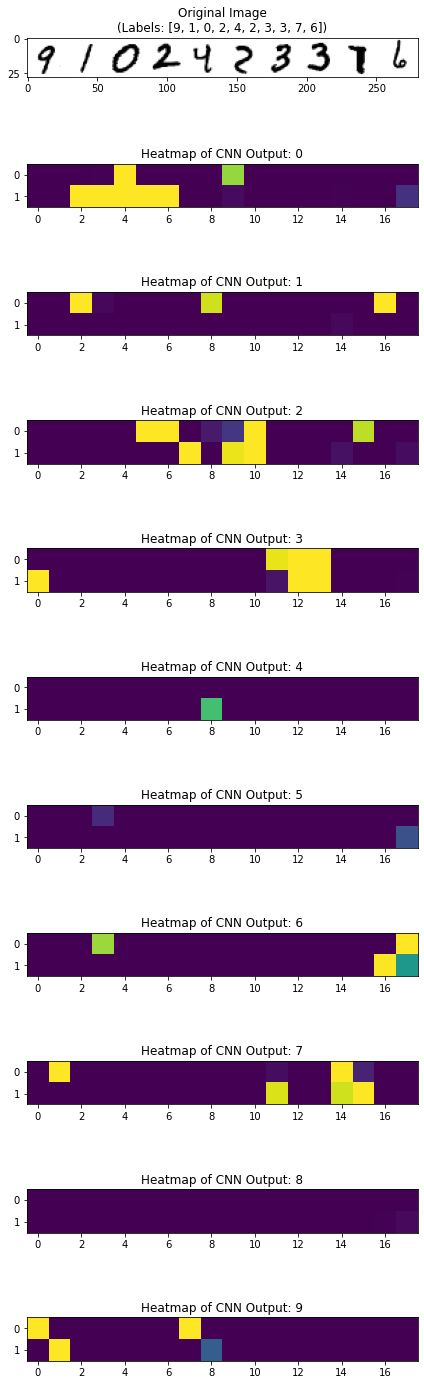

In [28]:
for img, label in train_loader:
    fig = plt.figure(figsize=(6, 20))
    axs = fig.subplots(11, 1)
    
    ax1, axs = axs[0], axs[1:]
    
    # Take the first set of numbers...
    num_nums = min(batch_size, 10)
    
    img = torch.cat([p for p in img[:num_nums]], dim=1)
    
    # Network doesn't apply the softmax when we disable pooling, so we apply it here.
    # This places all the scores between 0 and 1, and emphasises the highest score. 
    single_res_grid = torch.softmax(res_net.forward(img.reshape(1, 28, num_nums * 28), False), -1)[0]
    
    ax1.imshow(img.cpu().detach().numpy(), cmap="Greys")
    ax1.set_title(f"Original Image\n(Labels: {[int(l) for l in label[:num_nums]]})")
    
    for i, ax in enumerate(axs):
        ax.set_title(f"Heatmap of CNN Output: {i}")
        total_len = single_res_grid[:, :, i]
        ax.imshow(single_res_grid[:, :, i].cpu().detach().numpy(), vmin=0, vmax=1)
    
    fig.tight_layout()
    fig.show()
    
    break